# MSc Thesis - Hugo Stam

### Example 02 - Offshore Port System - Barges

<img src="Figures/system_layout_alternative_2B.png" style="width:1000px">

##### Investment Strategy Simulation - Adaptive terminal planning in the light of an uncertain future

* [**0. Prepare inputs:**](#0.-Prepare-inputs)<br>
   * [**0.1 Generate demand forecast scenario:**](#0.1-Generate-demand-forecast-scenario)<br>
   * [**0.2 Generate vessels:**](#0.2-Generate-vessels)<br>
* [**1. Instatiate system components:**](#1.-Instatiate-system-components)<br>
* [**2. Start simulation:**](#2.-Strart-simulation)<br>
* [**3. Report all elements:**](#3.-Report-all-elements)<br>

In [1]:
# packages for data handling
import numpy as np
import pandas as pd

# packages for figures
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import FormatStrFormatter
# %matplotlib inline
%matplotlib notebook
import seaborn as sns
sns.set(style="ticks")

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

# OpenTISim package
from opentisim import container_objects
from opentisim import container_defaults
from opentisim import container_system_offshore_barge

# Pretty-print a Python object to a stream
from pprint import pprint

# Jupyter Widgets
import ipywidgets as widgets
from IPython.display import HTML

# Scroll to specific cell
from jupyter_helpers.utilities import scroll_to_current_cell

# no warnings
import warnings
warnings.filterwarnings('ignore')

# 0. Prepare inputs

In [2]:
# iPython Widgests
life_cycle = widgets.IntSlider(value=10, min=10, max=30, step=5, description='Life cycle:')
annual_demand = widgets.IntSlider(value=1000000, min=500000, max=2000000, step=50000, description='Demand:')
offshore_onshore_distance = widgets.IntSlider(value=40, min=20, max=60, step=20, description='Distance:')

container_ship = widgets.Dropdown(options=[('Post Panamax I (6,000 TEU)', 6000),
                                           ('New-Panamax (12,500 TEU)', 12500),
                                           ('ULCS (21,000 TEU)', 21000)], 
                                  value=12500, description='OGV:')

barge = widgets.Dropdown(options=[('Small (200 TEU)', 200), 
                                  ('Medium (250 TEU)', 250),
                                  ('Large (300 TEU)', 300)], 
                         value=250, description='Barge:')

foreshore_slope = widgets.Dropdown(options=[('Gently (3 km/m)', 3.0), 
                                            ('Average (2 km/m)', 2.0),
                                            ('Steep (1 km/m)', 1.0)], 
                                   value=2.0, description='Slope:')

print('\033[1m*** Input Values \033[0m')
display(annual_demand, offshore_onshore_distance, container_ship, barge, 
        foreshore_slope, life_cycle)

*** Input Values 


IntSlider(value=1000000, description='Demand:', max=2000000, min=500000, step=50000)

IntSlider(value=40, description='Distance:', max=60, min=20, step=20)

Dropdown(description='OGV:', index=1, options=(('Post Panamax I (6,000 TEU)', 6000), ('New-Panamax (12,500 TEU…

Dropdown(description='Barge:', index=1, options=(('Small (200 TEU)', 200), ('Medium (250 TEU)', 250), ('Large …

Dropdown(description='Slope:', index=1, options=(('Gently (3 km/m)', 3.0), ('Average (2 km/m)', 2.0), ('Steep …

IntSlider(value=10, description='Life cycle:', max=30, min=10, step=5)

In [3]:
offshore_distance = offshore_onshore_distance.value
demand = annual_demand.value
design_container_ship = container_ship.value
design_barge = barge.value
slope = foreshore_slope.value
lifecycle = life_cycle.value

print('The offshore distance:', offshore_distance, 'km')
print('The annual demand:', demand, 'TEU')
print('The design container ship capacity:', design_container_ship, 'TEU')
print('The design barge capacity:', design_barge, 'TEU')
print('The slope of the foreshore:', slope, 'in km reach per meter water depth')
print('The design life cycle:', lifecycle, 'years')

avg_parcel = design_container_ship / 8

startyear = 2020

The offshore distance: 40 km
The annual demand: 1000000 TEU
The design container ship capacity: 12500 TEU
The design barge capacity: 250 TEU
The slope of the foreshore: 2.0 in km reach per meter water depth
The design life cycle: 10 years


## 0.1 Generate demand forecast scenario

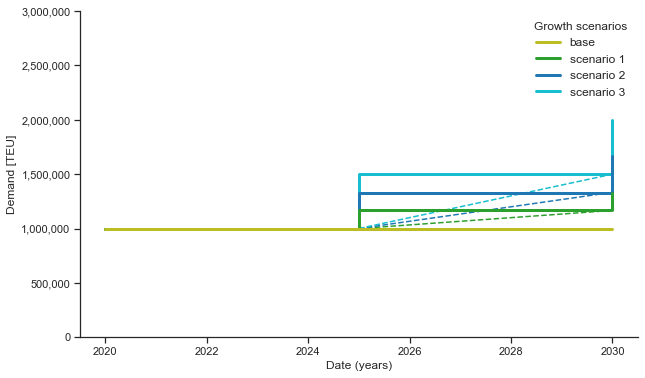

In [4]:
container = demand  # TEU
years = list(range(startyear, startyear+lifecycle+1))

trend_1 = []
trend_2 = []
trend_3 = []

for i in range(lifecycle-4):
    trend_1.append(container +   500_000/15 * i)
    trend_2.append(container + 1_000_000/15 * i)
    trend_3.append(container + 1_500_000/15 * i)

demand_0 = []
demand_1 = []
demand_2 = []
demand_3 = []

for year in years:
    if year < 2025:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.00))
        demand_2.append(int(container * 1.00))
        demand_3.append(int(container * 1.00))
        
    elif year < 2030:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.17))
        demand_2.append(int(container * 1.33))
        demand_3.append(int(container * 1.50))
    elif year < 2035:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.33))
        demand_2.append(int(container * 1.67))
        demand_3.append(int(container * 2.00))
    else:
        demand_0.append(int(container * 1.00))
        demand_1.append(int(container * 1.50))
        demand_2.append(int(container * 2.00))
        demand_3.append(int(container * 2.50))

# figure 
plt.figure(figsize=(10,6))

plt.plot(years[5:lifecycle+1], trend_1, color='tab:green', linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_2, color='tab:blue' , linestyle='--', zorder=0)
plt.plot(years[5:lifecycle+1], trend_3, color='tab:cyan' , linestyle='--', zorder=0)

plt.step(years, demand_0, color='tab:olive', linewidth=3, label='base', where='post', zorder=4)
plt.step(years, demand_1, color='tab:green', linewidth=3, label='scenario 1', where='post', zorder=3)
plt.step(years, demand_2, color='tab:blue' , linewidth=3, label='scenario 2', where='post', zorder=2)
plt.step(years, demand_3, color='tab:cyan' , linewidth=3, label='scenario 3', where='post', zorder=1)
    
plt.xlabel("Date (years)", fontsize='large')

if lifecycle == 20:
    plt.xticks([2020, 2025, 2030, 2035, 2040])

plt.yticks([0, 0.5e6, 1e6, 1.5e6, 2e6, 2.5e6, 3e6],
           [0, '500,000', '1,000,000', '1,500,000', '2,000,000', '2,500,000', '3,000,000'])
plt.ylabel('Demand [TEU]', fontsize='large')

plt.legend(loc='best', title='Growth scenarios', title_fontsize='large', fontsize='large', frameon=False)

# figure aesthetics
plt.grid(False, which='major')
sns.despine(top=True)

# save fig
if lifecycle == 20:
    plt.savefig("SaveFigures/growth_scenarios.png")

In [5]:
if lifecycle == 20:
    years = years[0:20]
    demand_0 = demand_0[0:20]
    demand_1 = demand_1[0:20]
    demand_2 = demand_2[0:20]
    demand_3 = demand_3[0:20]
    
if lifecycle == 10:
    years = years[0:10]
    demand_0 = demand_0[0:10]
    demand_1 = demand_1[0:10]
    demand_2 = demand_2[0:10]
    demand_3 = demand_3[0:10]

# print('Years: ', len(years), years)    
# print('Demand:', len(demand_2), demand_2)

In [6]:
years = list(range(startyear, startyear + lifecycle))
        
scenario_demand = demand_2
scenario_data={'year': years, 'volume': scenario_demand}
# print(scenario_data)

In [7]:
# instantiate Commodity objects, the inputs for the Commodity class
if design_container_ship == 6000:
    container_defaults.container_data['post_panamax_I_perc'] = 100
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 0

if design_container_ship == 12500:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 100
    container_defaults.container_data['ULCS_perc'] = 0
    
if design_container_ship == 21000:
    container_defaults.container_data['post_panamax_I_perc'] = 0
    container_defaults.container_data['new_panamax_perc'] = 0
    container_defaults.container_data['ULCS_perc'] = 100
    
# print(container_defaults.container_data)

# ladens
container = container_objects.Commodity(**container_defaults.container_data)
container.scenario_data = pd.DataFrame(data=scenario_data)
# print(container)
# print(container.scenario_data)

# combine
demand = [container]

## 0.2 Generate vessels

In [8]:
# instantiate vessels
fully_cellular = container_objects.Vessel(**container_defaults.fully_cellular_data)
panamax = container_objects.Vessel(**container_defaults.panamax_data)
panamax_max = container_objects.Vessel(**container_defaults.panamax_max_data)
post_panamax_I = container_objects.Vessel(**container_defaults.post_panamax_I_data)
post_panamax_II = container_objects.Vessel(**container_defaults.post_panamax_II_data)
new_panamax = container_objects.Vessel(**container_defaults.new_panamax_data)
VLCS = container_objects.Vessel(**container_defaults.VLCS_data)
ULCS = container_objects.Vessel(**container_defaults.ULCS_data)

vessels = [fully_cellular, panamax, panamax_max, post_panamax_I, post_panamax_II, new_panamax, VLCS, ULCS] 

# 1. Instatiate system components

## 1.1 Terminal system

Specify the variables

In [9]:
OffshoreBarge = container_system_offshore_barge.System(
                startyear = startyear,
                lifecycle = lifecycle,
                stack_equipment = 'rtg',
                laden_stack = 'rtg',
                elements = demand + vessels,
                crane_type_defaults = container_defaults.sts_crane_data,
                offshore_distance = offshore_distance,
                onshore_perc = 0.75, 
                barge_type = 'medium',
                foreshore_slope = slope,
                bathymetry_factor = 0.50,
                allowable_berth_occupancy = 0.70,
                offshore_dwell_time = 2.0,
                transhipment_ratio = 0.00,
                debug = True)

# 2. Start simulation

This method automatically generates investment decisions, parametrically derived from demand trends and a number of investment triggers.

Apply frame of reference style decisions while stepping through each year of the terminal lifecycle and check if investment is needed (in light of strategic objective, operational objective, QSC, decision recipe, intervention method):
    1. for each year evaluate the demand of each commodity (see 0.1 Demand forecast scenario)
    2. for each year evaluate the various investment decisions
    3. for each year calculate the energy costs (requires insight in realized demands)
    4. for each year calculate the demurrage costs (requires insight in realized demands)
    5. for each year calculate terminal revenues
    6. collect all cash flows (capex, opex, {revenues})
    7. calculate PV's {and aggregate to NPV}

In [10]:
scroll_to_current_cell(preserve=True)
OffshoreBarge.simulate()


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2020.

Simulate year: 2020
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000

  Start analysis:
     Berth occupancy planned (@ start of year): inf
     Berth occupancy online  (@ start of year): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): inf
     Berth occupancy online  (after adding Berth): inf

  >>> Number of OGV berths: 1
     >> The length of the design vessel is 366 m
     >> The length of the quay is 396 m
     >> The water depth at the quay is 19 m

     >> The length of the quay that needs to be built 396 m

  *** add Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,28785033.6,0.00,0.00
1,2021,19190022.4,0.00,0.00
2,2022,0.0,405250.56,405250.56
3,2023,0.0,405250.56,405250.56
4,2024,0.0,405250.56,405250.56


     Berth occupancy planned (after adding Quay): inf
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 3.338
     Berth occupancy online  (after adding Crane): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 1.891
     Berth occupancy online  (after adding Crane): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 1.409
     Berth occupancy online  (after adding Crane): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): 1.187
     Berth occupancy online  (after adding Berth): inf

  >>> Number of OGV berths: 2
     >> The length of the design vessel is 366 m
     >> The length of the quay is 853 m
     >> The water depth at the quay is 19 m

     >> The length of the quay that needs to be built 457 m

  *** add Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,33001811.4,0.000,0.000
1,2021,22001207.6,0.000,0.000
2,2022,0.0,467880.192,467880.192
3,2023,0.0,467880.192,467880.192
4,2024,0.0,467880.192,467880.192


     Berth occupancy planned (after adding Quay): 1.187
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.946
     Berth occupancy online  (after adding Crane): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.801
     Berth occupancy online  (after adding Crane): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.705
     Berth occupancy online  (after adding Crane): inf

  *** add Berth to elements
     Berth occupancy planned (after adding Berth): 0.63
     Berth occupancy online  (after adding Berth): inf

  >>> Number of OGV berths: 3
     >> The length of the design vessel is 366 m
     >> The length of the quay is 1,272 m
     >> The water depth at the quay is 19 m

     >> The length of the quay that needs to be built 419 m

  *** add Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,30376660.2,0.000,0.000
1,2021,20251106.8,0.000,0.000
2,2022,0.0,428890.176,428890.176
3,2023,0.0,428890.176,428890.176
4,2024,0.0,428890.176,428890.176


     Berth occupancy planned (after adding Quay): 0.63
     Berth occupancy online  (after adding Quay): inf

  *** add STS crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,11695500.0,0.0,0.0,0.0
2,2022,0.0,305100.0,101700.0,687500.0
3,2023,0.0,305100.0,101700.0,687500.0
4,2024,0.0,305100.0,101700.0,687500.0


     Berth occupancy planned (after adding Crane): 0.561
     Berth occupancy online  (after adding Crane): inf

     STS cranes online            (@ start of year): 0
     STS cranes planned           (@ start of year): 7
     Horizontal transport online  (@ start of year): 0
     Horizontal transport planned (@ start of year): 0

  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,114000.0,0.0,0.0,170500.0,0.0,0.0
2,2022,0.0,11300.0,125000.0,0.0,16950.0,187500.0
3,2023,0.0,11300.0,125000.0,0.0,16950.0,187500.0
4,2024,0.0,11300.0,125000.0,0.0,16950.0,187500.0


     Stack Capacity planned  (@ start of year): 0
     Stack Capacity online   (@ start of year): 0
     Stack Capacity required (@ start of year): 8608
     Laden and Reefer Ground Slots required (@ start of year): 1722

  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,2071150.0,0.0,2897350.0,0.0
2,2022,0.0,165240.0,0.0,247860.0
3,2023,0.0,165240.0,0.0,247860.0
4,2024,0.0,165240.0,0.0,247860.0


     Empty Stack capacity planned  (@ start of year): 0
     Empty Stack capacity online   (@ start of year): 0
     Empty Stack capacity required (@ start of year): 714
     Empty Ground Slots required   (@ start of year): 119

  *** add Empty Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,759400.0,0.0,1126600.0,0.0
2,2022,0.0,73440.0,0.0,110160.0
3,2023,0.0,73440.0,0.0,110160.0
4,2024,0.0,73440.0,0.0,110160.0


  *** add Empty Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,759400.0,0.0,1126600.0,0.0
2,2022,0.0,73440.0,0.0,110160.0
3,2023,0.0,73440.0,0.0,110160.0
4,2024,0.0,73440.0,0.0,110160.0


     OOG Slots planned  (@ start of year): 0
     OOG Slots online   (@ start of year): 0
     OOG Slots required (@ start of year): 119

  *** add OOG stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,1705000.0,0.0,2545000.0,0.0
2,2022,0.0,168000.0,0.0,252000.0
3,2023,0.0,168000.0,0.0,252000.0
4,2024,0.0,168000.0,0.0,252000.0


  *** add OOG stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,1705000.0,0.0,2545000.0,0.0
2,2022,0.0,168000.0,0.0,252000.0
3,2023,0.0,168000.0,0.0,252000.0
4,2024,0.0,168000.0,0.0,252000.0


     Total Ground Slots required   (@ start of year):  1,841
     Total Stack capacity required (@ start of year):  9,400 TEU
     Total Stack capacity online   (@ start of year):  0 TEU

     Number of stack Equipment online (@ start of year): 0

     Empty handlers planned (@ start of year): 0
  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,505000.0,0.0,0.0,755000.0,0.0,0.0
2,2022,0.0,10000.0,125000.0,0.0,15000.0,187500.0
3,2023,0.0,10000.0,125000.0,0.0,15000.0,187500.0
4,2024,0.0,10000.0,125000.0,0.0,15000.0,187500.0



     Offshore barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): inf

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 114630.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 1
  >> nr of offshore barge quays:  0
     >> The length of the quay is 130 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 130 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,9198564.0,0.0,0.0
1,2021,6132376.0,0.0,0.0
2,2022,0.0,135184.4,135184.4
3,2023,0.0,135184.4,135184.4
4,2024,0.0,135184.4,135184.4


     Offshore barge berth capacity planned     (@ start of year): 114630.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 9.596

  >> nr of offshore barge cranes: 0
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 1
     Offshore barge berth capacity planned (after adding Crane): 114630.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 2
     Offshore barge berth capacity planned (after adding Crane): 114630.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 229270.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 2
  >> nr of offshore barge quays:  1
     >> The length of the quay is 268 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 138 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,9727706.4,0.00,0.00
1,2021,6485137.6,0.00,0.00
2,2022,0.0,143503.44,143503.44
3,2023,0.0,143503.44,143503.44
4,2024,0.0,143503.44,143503.44


     Offshore barge berth capacity planned     (@ start of year): 229270.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 4.798

  >> nr of offshore barge cranes: 2
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 3
     Offshore barge berth capacity planned (after adding Crane): 229270.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 343900.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 3
  >> nr of offshore barge quays:  2
     >> The length of the quay is 394 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967064.2,0.00,0.00
1,2021,5978042.8,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 343900.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 3.199

  >> nr of offshore barge cranes: 3
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 4
     Offshore barge berth capacity planned (after adding Crane): 343900.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 458540.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 4
  >> nr of offshore barge quays:  3
     >> The length of the quay is 521 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967064.2,0.00,0.00
1,2021,5978042.8,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 458540.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 2.399

  >> nr of offshore barge cranes: 4
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 5
     Offshore barge berth capacity planned (after adding Crane): 458540.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 6
     Offshore barge berth capacity planned (after adding Crane): 458540.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 573170.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 5
  >> nr of offshore barge quays:  4
     >> The length of the quay is 647 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967063.6,0.00,0.00
1,2021,5978042.4,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 573170.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.919

  >> nr of offshore barge cranes: 6
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 7
     Offshore barge berth capacity planned (after adding Crane): 573170.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 687800.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 6
  >> nr of offshore barge quays:  5
     >> The length of the quay is 774 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967064.2,0.00,0.00
1,2021,5978042.8,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 687800.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.599

  >> nr of offshore barge cranes: 7
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 8
     Offshore barge berth capacity planned (after adding Crane): 687800.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 802440.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 7
  >> nr of offshore barge quays:  6
     >> The length of the quay is 900 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967064.2,0.00,0.00
1,2021,5978042.8,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 802440.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.371

  >> nr of offshore barge cranes: 8
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 9
     Offshore barge berth capacity planned (after adding Crane): 802440.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 10
     Offshore barge berth capacity planned (after adding Crane): 802440.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 917070.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 8
  >> nr of offshore barge quays:  7
     >> The length of the quay is 1,027 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967064.2,0.00,0.00
1,2021,5978042.8,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 917070.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.199

  >> nr of offshore barge cranes: 10
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 11
     Offshore barge berth capacity planned (after adding Crane): 917070.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1031700.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 9
  >> nr of offshore barge quays:  8
     >> The length of the quay is 1,153 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967063.6,0.00,0.00
1,2021,5978042.4,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 1031700.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.066

  >> nr of offshore barge cranes: 11
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 12
     Offshore barge berth capacity planned (after adding Crane): 1031700.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of offshore barge berths: 10
  >> nr of offshore barge quays:  9
     >> The length of the quay is 1,280 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,8967064.2,0.00,0.00
1,2021,5978042.8,0.00,0.00
2,2022,0.0,131544.82,131544.82
3,2023,0.0,131544.82,131544.82
4,2024,0.0,131544.82,131544.82


     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96

  >> nr of offshore barge cranes: 12
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of offshore barge cranes: 13
     Offshore barge berth capacity planned (after adding Crane): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 0 [TEU/yr]


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr


>>> Total offshore land use 27.7 ha
>>> Total onshore land use 12.8 ha
length 366
draught 15.2
beam 49.0
  *** add Access Channel to elements
channel_width 480 m
channel_depth 17 m
channel_length 0 m
channel_volume 0 m3
turning_circle_diameter 658 m3
turning_circle_volume 0 m3
berth_pocket_width 98 m
berth_pocket_volume 0 m3
dredging_volume 0 m3

channel_length_max 35,400 m
excavation_depth 0 m


,Year
0,2020
1,2021
2,2022
3,2023
4,2024



>>> Total offshore land use 27.7 ha
     Reclamation area planned  (@ start of year): 0 ha
     Reclamation area online   (@ start of year): 0 ha
     Reclamation area required (@ start of year): 276641.0 ha

  *** add Reclamation to elements
     >> draught vessel 15.2 m
     >> natural depth 20.0 m
     >> water depth 20.0 m

     >> reclamation area 277,000 m2
     >> reclamation volume 5,533,000 m3

     >> reclamation area required 276641.2
     >> reclamation volume required 5,533,000 m3


,Year,Reclamation,Coastal Structures Maintenance
0,2020,126206868.0,0.00
1,2021,0.0,570465.68
2,2022,0.0,570465.68
3,2023,0.0,570465.68
4,2024,0.0,570465.68



>>> Total offshore land use 27.7 ha

>>> Total offshore land use 27.7 ha
     Reclamation area planned  (@ start of year): 0 ha
     Reclamation area online   (@ start of year): 0 ha
     Reclamation area required (@ start of year): 526.0 ha

  *** add Revetment to elements

     >> revetment_length 530 m


,Year,Coastal Protection,Coastal Structures Maintenance
0,2020,94674045.0,0.0
1,2021,0.0,946740.0
2,2022,0.0,946740.0
3,2023,0.0,946740.0
4,2024,0.0,946740.0



>>> Total offshore land use 27.7 ha

     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 0
nr barges required: 13
     Barge Capacity planned  (@ start of year): 0
     Barge Capacity online   (@ start of year): 0
     Barge Capacity required (@ start of year): 750000

  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 1
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 2
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 3
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 4
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 5
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 6
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 7
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 8
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 9
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 10
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 11
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 12
nr barges required: 13
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.000000,0.0,0.0
1,2021,4000000.0,0.000000,0.0,0.0
2,2022,0.0,317933.657674,200000.0,225000.0
3,2023,0.0,317933.657674,200000.0,225000.0
4,2024,0.0,317933.657674,200000.0,225000.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 13
nr barges required: 13
  *** add Barge Channel to elements

Calibration Barge Channel
barge_channel_width 127 m
barge_channel_depth 7 m
barge_channel_length 14,000 m
barge_channel_volume 6,242,600 m3
barge_turning_circle_diameter 180 m
barge_turning_circle_volume 178,128 m3
barge_berth_pocket_width 2

,Year,Capital Dredging,Maintenance Dredging
0,2020,22237814.0,0.000000e+00
1,2021,22237814.0,0.000000e+00
2,2022,0.0,1.601123e+06
3,2023,0.0,1.601123e+06
4,2024,0.0,1.601123e+06



     Onshore barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): inf [-]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 114630.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 1
  >> nr of onshore barge quays: 0
     >> The length of the quay is 130 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 130 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4804044.0,0.0,0.0
1,2021,3202696.0,0.0,0.0
2,2022,0.0,61942.4,61942.4
3,2023,0.0,61942.4,61942.4
4,2024,0.0,61942.4,61942.4


     Onshore barge berth capacity planned     (@ start of year): 114633.792 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 7.197 [-]

  >> nr of onshore barge cranes: 0
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 1
     Onshore barge crane capacity planned (after adding Crane): 114630.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 2
     Onshore barge crane capacity planned (after adding Crane): 114630.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 229270.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 2
  >> nr of onshore barge quays: 1
     >> The length of the quay is 268 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 138 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,5062754.4,0.00,0.00
1,2021,3375169.6,0.00,0.00
2,2022,0.0,65754.24,65754.24
3,2023,0.0,65754.24,65754.24
4,2024,0.0,65754.24,65754.24


     Onshore barge berth capacity planned     (@ start of year): 229267.584 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 3.598 [-]

  >> nr of onshore barge cranes: 2
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 3
     Onshore barge crane capacity planned (after adding Crane): 229270.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 343900.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 3
  >> nr of onshore barge quays: 2
     >> The length of the quay is 394 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690858.2,0.00,0.00
1,2021,3127238.8,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Onshore barge berth capacity planned     (@ start of year): 343901.376 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 2.399 [-]

  >> nr of onshore barge cranes: 3
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 4
     Onshore barge crane capacity planned (after adding Crane): 343900.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 458540.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 4
  >> nr of onshore barge quays: 3
     >> The length of the quay is 521 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690858.2,0.00,0.00
1,2021,3127238.8,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Onshore barge berth capacity planned     (@ start of year): 458535.168 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.799 [-]

  >> nr of onshore barge cranes: 4
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 5
     Onshore barge crane capacity planned (after adding Crane): 458540.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 6
     Onshore barge crane capacity planned (after adding Crane): 458540.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 573170.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 5
  >> nr of onshore barge quays: 4
     >> The length of the quay is 647 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690857.6,0.00,0.00
1,2021,3127238.4,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Onshore barge berth capacity planned     (@ start of year): 573168.96 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.439 [-]

  >> nr of onshore barge cranes: 6
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 7
     Onshore barge crane capacity planned (after adding Crane): 573170.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 687800.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 6
  >> nr of onshore barge quays: 5
     >> The length of the quay is 774 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690858.2,0.00,0.00
1,2021,3127238.8,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Onshore barge berth capacity planned     (@ start of year): 687802.752 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.199 [-]

  >> nr of onshore barge cranes: 7
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 8
     Onshore barge crane capacity planned (after adding Crane): 687800.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 802440.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 7
  >> nr of onshore barge quays: 6
     >> The length of the quay is 900 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690858.2,0.00,0.00
1,2021,3127238.8,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Onshore barge berth capacity planned     (@ start of year): 802436.544 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.028 [-]

  >> nr of onshore barge cranes: 8
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 9
     Onshore barge crane capacity planned (after adding Crane): 802440.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 10
     Onshore barge crane capacity planned (after adding Crane): 802440.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 917070.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of onshore barge berths: 8
  >> nr of onshore barge quays: 7
     >> The length of the quay is 1,027 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690858.2,0.00,0.00
1,2021,3127238.8,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Onshore barge berth capacity planned     (@ start of year): 917070.336 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 0.9 [-]

  >> nr of onshore barge cranes: 10
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 11
     Onshore barge crane capacity planned (after adding Crane): 917070.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 0 [TEU/yr]

     Hinterland Gate capacity planned     (@ start of year): 0
     Hinterland Gate capacity online      (@ start of year): 0
     Hinterland Gate capacity required    (@ start of year): 0
     Hinterland Gate service rate planned (@ start of year): inf

  *** add Hinterland Gate to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0
1,2021,107187.0,0.0,0.0
2,2022,0.0,600.0,250000.0
3,2023,0.0,600.0,250000.0
4,2024,0.0,600.0,250000.0


     >> nr of hinterland lanes: 1
  *** add Hinterland Gate to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0
1,2021,107187.0,0.0,0.0
2,2022,0.0,600.0,250000.0
3,2023,0.0,600.0,250000.0
4,2024,0.0,600.0,250000.0


     >> nr of hinterland lanes: 2
  *** add Hinterland Gate to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0
1,2021,107187.0,0.0,0.0
2,2022,0.0,600.0,250000.0
3,2023,0.0,600.0,250000.0
4,2024,0.0,600.0,250000.0


     >> nr of hinterland lanes: 3
  *** add Hinterland Gate to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0
1,2021,107187.0,0.0,0.0
2,2022,0.0,600.0,250000.0
3,2023,0.0,600.0,250000.0
4,2024,0.0,600.0,250000.0


     >> nr of hinterland lanes: 4
  *** add Hinterland Gate to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0
1,2021,107187.0,0.0,0.0
2,2022,0.0,600.0,250000.0
3,2023,0.0,600.0,250000.0
4,2024,0.0,600.0,250000.0


     >> nr of hinterland lanes: 5

     Hinterland barge berth capacity planned     (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): inf [-]

  *** add Hinterland Barge Berth to elements
     Hinterland barge berth capacity planned (after adding Berth): 114630.0 [TEU/yr]
     Hinterland barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of hinterland barge berths: 1
  >> nr of hinterland barge quays: 0
     >> The length of the quay is 130 m
     >> The water depth at the quay is 9 m

     >> The length of the hinterland barge quay that needs to be built 130 m

  *** add Hinterland Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4804044.0,0.0,0.0
1,2021,3202696.0,0.0,0.0
2,2022,0.0,61942.4,61942.4
3,2023,0.0,61942.4,61942.4
4,2024,0.0,61942.4,61942.4


     Hinterland barge berth capacity planned     (@ start of year): 114633.792 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 275000.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 2.399 [-]

  >> nr of hinterland barge cranes: 0
  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 1
     Hinterland barge crane capacity planned (after adding Crane): 114630.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 2
     Hinterland barge crane capacity planned (after adding Crane): 114630.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Hinterland Barge Berth to elements
     Hinterland barge berth capacity planned (after adding Berth): 229270.0 [TEU/yr]
     Hinterland barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of hinterland barge berths: 2
  >> nr of hinterland barge quays: 1
     >> The length of the quay is 268 m
     >> The water depth at the quay is 9 m

     >> The length of the hinterland barge quay that needs to be built 138 m

  *** add Hinterland Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,5062754.4,0.00,0.00
1,2021,3375169.6,0.00,0.00
2,2022,0.0,65754.24,65754.24
3,2023,0.0,65754.24,65754.24
4,2024,0.0,65754.24,65754.24


     Hinterland barge berth capacity planned     (@ start of year): 229267.584 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 275000.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 1.199 [-]

  >> nr of hinterland barge cranes: 2
  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 3
     Hinterland barge crane capacity planned (after adding Crane): 229270.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 0 [TEU/yr]

  *** add Hinterland Barge Berth to elements
     Hinterland barge berth capacity planned (after adding Berth): 343900.0 [TEU/yr]
     Hinterland barge berth capacity online  (after adding Berth): 0 [TEU/yr]

  >> nr of hinterland barge berths: 3
  >> nr of hinterland barge quays: 2
     >> The length of the quay is 394 m
     >> The water depth at the quay is 9 m

     >> The length of the hinterland barge quay that needs to be built 126 m

  *** add Hinterland Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,4690858.2,0.00,0.00
1,2021,3127238.8,0.00,0.00
2,2022,0.0,60274.72,60274.72
3,2023,0.0,60274.72,60274.72
4,2024,0.0,60274.72,60274.72


     Hinterland barge berth capacity planned     (@ start of year): 343901.376 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 275000.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 0.8 [-]

  >> nr of hinterland barge cranes: 3
  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,7797000.0,0.0,0.0,0.0
2,2022,0.0,135600.0,67800.0,187500.0
3,2023,0.0,135600.0,67800.0,187500.0
4,2024,0.0,135600.0,67800.0,187500.0


  >> nr of onshore barge cranes: 4
     Hinterland barge crane capacity planned (after adding Crane): 343900.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 0 [TEU/yr]


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2021.

Simulate year: 2021
  Total vessel calls: 640
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 640
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1000000

  Start analysis:
     Berth occupancy planned (@ start of year): 0.561
     Berth occupancy online  (@ start of year): inf

     STS cranes online            (@ start of year): 0
     STS cranes planned           (@ start of year): 7
     Horizontal transport online  (@ start of year): 0
     Horizontal transport planned (@ start of year): 35

     Stack Capacity planned  (@ start of year): 9000
     Stack Capacity online   (

,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,1405000.0,0.0,0.0,2107500.0,0.0,0.0
2,2022,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
3,2023,0.0,700000.0,125000.0,0.0,1050000.0,187500.0
4,2024,0.0,700000.0,125000.0,0.0,1050000.0,187500.0


     Empty handlers planned (@ start of year): 35

     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr


>>> Total offshore land use 27.7 ha
>>> Total onshore land use 20.1 ha
  *** add General Services to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.000,0.000000e+00,0.000000
1,2021,34010603.0,0.000,3.382059e+07,0.000000
2,2022,0.0,510159.045,0.000000e+00,507308.833125
3,2023,0.0,510159.045,0.000000e+00,507308.833125
4,2024,0.0,510159.045,0.000000e+00,507308.833125


length 366
draught 15.2
beam 49.0

>>> Total offshore land use 28.4 ha
     Reclamation area planned  (@ start of year): 276641.0 ha
     Reclamation area online   (@ start of year): 276641.0 ha
     Reclamation area required (@ start of year): 284241.0 ha

  *** add Reclamation to elements
     >> draught vessel 15.2 m
     >> natural depth 20.0 m
     >> water depth 20.0 m

     >> reclamation area 8,000 m2
     >> reclamation volume 152,000 m3

     >> reclamation area required 284241.2
     >> reclamation volume required 5,685,000 m3


,Year,Reclamation,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,21280800.0,0.0
3,2023,0.0,193808.0
4,2024,0.0,193808.0



>>> Total offshore land use 28.4 ha

>>> Total offshore land use 28.4 ha
     Reclamation area planned  (@ start of year): 526.0 ha
     Reclamation area online   (@ start of year): 526.0 ha
     Reclamation area required (@ start of year): 533.0 ha

  *** add Revetment to elements

     >> revetment_length 10 m


,Year,Coastal Protection,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,1291650.0,0.0
3,2023,0.0,12916.0
4,2024,0.0,12916.0



>>> Total offshore land use 28.4 ha

     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1100000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.96


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 13
nr barges required: 13
     Barge Capacity planned  (@ start of year): 773562
     Barge Capacity online   (@ start of year): 773562
     Barge Capacity required (@ start of year): 750000


     Onshore barge berth capacity planned     (@ start of year): 9

nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 13
nr barges required: 13
     Barge Capacity planned  (@ start of year): 773562
     Barge Capacity online   (@ start of year): 773562
     Barge Capacity required (@ start of year): 750000


     Onshore barge berth capacity planned     (@ start of year): 917070.0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 917070.0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 825000.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 0.9 [-]

     Hinterland Gate capacity planned     (@ start of year): 300
     Hinterland Gate capacity online      (@ start of year): 300
     Hinterl

,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


     Berth occupancy planned (after adding Crane): 0.679
     Berth occupancy online  (after adding Crane): 0.747

     STS cranes online            (@ start of year): 7
     STS cranes planned           (@ start of year): 8
     Horizontal transport online  (@ start of year): 35
     Horizontal transport planned (@ start of year): 35

  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Tractor Trailer to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


     Stack Capacity planned  (@ start of year): 9000
     Stack Capacity online   (@ start of year): 9000
     Stack Capacity required (@ start of year): 11449
     Laden and Reefer Ground Slots required (@ start of year): 2290

  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  *** add Laden Stack to elements


,Year,Offshore Capex,Offshore Maintenance,Onshore Capex,Onshore Maintenance
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


     Empty Stack capacity planned  (@ start of year): 960
     Empty Stack capacity online   (@ start of year): 960
     Empty Stack capacity required (@ start of year): 950
     Empty Ground Slots required   (@ start of year): 158

     OOG Slots planned  (@ start of year): 200
     OOG Slots online   (@ start of year): 200
     OOG Slots required (@ start of year): 159

     Total Ground Slots required   (@ start of year):  2,448
     Total Stack capacity required (@ start of year):  12,600 TEU
     Total Stack capacity online   (@ start of year):  10,200 TEU

     Number of stack Equipment online (@ start of year): 21

     Empty handlers planned (@ start of year): 35
  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Empty Handler to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.276

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1260970.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 1146340.0 [TEU/yr]

  >> nr of offshore barge berths: 11
  >> nr of offshore barge quays:  10
     >> The length of the quay is 1,406 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Offshore barge berth capacity planned     (@ start of year): 1260970.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.16

  >> nr of offshore barge cranes: 13
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of offshore barge cranes: 14
     Offshore barge berth capacity planned (after adding Crane): 1260970.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1146340.0 [TEU/yr]

  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of offshore barge cranes: 15
     Offshore barge berth capacity planned (after adding Crane): 1260970.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1146340.0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1375610.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 1146340.0 [TEU/yr]

  >> nr of offshore barge berths: 12
  >> nr of offshore barge quays:  11
     >> The length of the quay is 1,533 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Offshore barge berth capacity planned     (@ start of year): 1375610.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 1.064

  >> nr of offshore barge cranes: 15
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of offshore barge cranes: 16
     Offshore barge berth capacity planned (after adding Crane): 1375610.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1146340.0 [TEU/yr]

  *** add Offshore Barge Berth to elements
     Offshore barge berth capacity planned (after adding Berth): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Berth): 1146340.0 [TEU/yr]

  >> nr of offshore barge berths: 13
  >> nr of offshore barge quays:  12
     >> The length of the quay is 1,659 m
     >> The water depth at the quay is 20 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Offshore Barge Quay to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982

  >> nr of offshore barge cranes: 16
  *** add Offshore Barge Crane to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Insurance,Offshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of offshore barge cranes: 17
     Offshore barge berth capacity planned (after adding Crane): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online  (after adding Crane): 1146340.0 [TEU/yr]


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr


>>> Total offshore land use 32.3 ha
>>> Total onshore land use 23.9 ha
length 366
draught 15.2
beam 49.0

>>> Total offshore land use 32.3 ha
     Reclamation area planned  (@ start of year): 284241.0 ha
     Reclamation area online   (@ start of year): 284241.0 ha
     Reclamation area required (@ start of year): 323045.0 ha

  *** add Reclamation to elements
     >> draught vessel 15.2 m
     >> natural depth 20.0 m
     >> water depth 20.0 m

     >> reclamation area 39,000 m2
     >> reclamation volume 776,000 m3

     >> reclamation area required 323045.00000000006
     >> reclamation volume required 6,461,000 m3


,Year,Reclamation,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0



>>> Total offshore land use 32.3 ha

>>> Total offshore land use 32.3 ha
     Reclamation area planned  (@ start of year): 533.0 ha
     Reclamation area online   (@ start of year): 533.0 ha
     Reclamation area required (@ start of year): 568.0 ha

  *** add Revetment to elements

     >> revetment_length 40 m


,Year,Coastal Protection,Coastal Structures Maintenance
0,2020,0.0,0.0
1,2021,0.0,0.0
2,2022,0.0,0.0
3,2023,0.0,0.0
4,2024,0.0,0.0



>>> Total offshore land use 32.3 ha

     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 13
nr barges required: 17
     Barge Capacity planned  (@ start of year): 773562
     Barge Capacity online   (@ start of year): 773562
     Barge Capacity required (@ start of year): 997500

  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 14
nr barges required: 17
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 15
nr barges required: 17
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 16
nr barges required: 17
  *** add Barge to elements
barge opex 742933 USD


,Year,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0



     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr

handling rate: 21.1 TEU/hr
barge capacity 250
sum of loading and unloading time: 26.0 hrs
sailing time: 3.0 hrs
total cycle time: 58.0 hrs or 2.4 days
annual cycles per barge: 119
annual barge capacity: 59504 TEU
nr barges online: 17
nr barges required: 17

     Onshore barge berth capacity planned     (@ start of year): 917070.0 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 917070.0 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 1097250.0 [TEU/yr]
     Onshore barge

,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Onshore barge berth capacity planned     (@ start of year): 1031704.128 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 917070.336 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 1097250.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 1.064 [-]

  >> nr of onshore barge cranes: 11
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of onshore barge cranes: 12
     Onshore barge crane capacity planned (after adding Crane): 1031700.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 917070.0 [TEU/yr]

  *** add Onshore Barge Berth to elements
     Onshore barge berth capacity planned (after adding Berth): 1146340.0 [TEU/yr]
     Onshore barge berth capacity online  (after adding Berth): 917070.0 [TEU/yr]

  >> nr of onshore barge berths: 10
  >> nr of onshore barge quays: 9
     >> The length of the quay is 1,280 m
     >> The water depth at the quay is 9 m

     >> The length of the barge quay that needs to be built 126 m

  *** add Onshore Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Onshore barge berth capacity planned     (@ start of year): 1146337.92 [TEU/yr]
     Onshore barge berth capacity online      (@ start of year): 917070.336 [TEU/yr]
     Onshore barge berth capacity required    (@ start of year): 1097250.0 [TEU/yr]
     Onshore barge berth service rate planned (@ start of year): 0.957 [-]

  >> nr of onshore barge cranes: 12
  *** add Onshore Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of onshore barge cranes: 13
     Onshore barge crane capacity planned (after adding Crane): 1146340.0 [TEU/yr]
     Onshore barge crane capacity online  (after adding Crane): 917070.0 [TEU/yr]

     Hinterland Gate capacity planned     (@ start of year): 300
     Hinterland Gate capacity online      (@ start of year): 300
     Hinterland Gate capacity required    (@ start of year): 351
     Hinterland Gate service rate planned (@ start of year): 1.169

  *** add Hinterland Gate to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     >> nr of hinterland lanes: 6

     Hinterland barge berth capacity planned     (@ start of year): 343900.0 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 343900.0 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 365750.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 1.064 [-]

  *** add Hinterland Barge Berth to elements
     Hinterland barge berth capacity planned (after adding Berth): 458540.0 [TEU/yr]
     Hinterland barge berth capacity online  (after adding Berth): 343900.0 [TEU/yr]

  >> nr of hinterland barge berths: 4
  >> nr of hinterland barge quays: 3
     >> The length of the quay is 521 m
     >> The water depth at the quay is 9 m

     >> The length of the hinterland barge quay that needs to be built 126 m

  *** add Hinterland Barge Quay to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance
0,2020,0.0,0.0,0.0
1,2021,0.0,0.0,0.0
2,2022,0.0,0.0,0.0
3,2023,0.0,0.0,0.0
4,2024,0.0,0.0,0.0


     Hinterland barge berth capacity planned     (@ start of year): 458535.168 [TEU/yr]
     Hinterland barge berth capacity online      (@ start of year): 343901.376 [TEU/yr]
     Hinterland barge berth capacity required    (@ start of year): 365750.0 [TEU/yr]
     Hinterland barge berth service rate planned (@ start of year): 0.798 [-]

  >> nr of hinterland barge cranes: 4
  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of onshore barge cranes: 5
     Hinterland barge crane capacity planned (after adding Crane): 458540.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 343900.0 [TEU/yr]

  *** add Hinterland Barge Crane to elements


,Year,Onshore Capex,Onshore Maintenance,Onshore Insurance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0


  >> nr of onshore barge cranes: 6
     Hinterland barge crane capacity planned (after adding Crane): 458540.0 [TEU/yr]
     Hinterland barge crane capacity online  (after adding Crane): 343900.0 [TEU/yr]


Offshore Port System - Barge Connection

Below, the various investment decisions are evaluated for the year 2026.

Simulate year: 2026
  Total vessel calls: 852
  Fully cellular calls: 0
  Panamax calls: 0
  Panamax max calls: 0
  Post Panamax I calls: 0
  Post Panamax II calls: 0
  New Panamax calls: 852
  VLCS calls: 0
  ULCS calls: 0
  Total cargo volume: 1330000

  Start analysis:
     Berth occupancy planned (@ start of year): 0.679
     Berth occupancy online  (@ start of year): 0.679

     STS cranes online            (@ start of year): 8
     STS cranes planned           (@ start of year): 8
     Horizontal transport online  (@ start of year): 40
     Horizontal transport planned (@ start of year): 40

     Stack Capacity planned  (@ start of year): 11700
     Stack Capacity

,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


  *** add Stack Equipment to elements


,Year,Offshore Capex,Offshore Maintenance,Offshore Labour,Onshore Capex,Onshore Maintenance,Onshore Labour
0,2020,0.0,0.0,0.0,0.0,0.0,0.0
1,2021,0.0,0.0,0.0,0.0,0.0,0.0
2,2022,0.0,0.0,0.0,0.0,0.0,0.0
3,2023,0.0,0.0,0.0,0.0,0.0,0.0
4,2024,0.0,0.0,0.0,0.0,0.0,0.0


     Empty handlers planned (@ start of year): 40

     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1146340.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start of year): 0.982


Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr


>>> Total offshore land use 32.3 ha
>>> Total onshore land use 25.8 ha
length 366
draught 15.2
beam 49.0

>>> Total offshore land use 32.3 ha
     Reclamation area planned  (@ start of year): 323045.0 ha
     Reclamation area online   (@ start of year): 323045.0 ha
     Reclamation area required (@ start of year): 323045.0 ha


>>> Total offshore land use 32.3 ha
     Reclamation area planned  (@ start of year): 568.0 ha
     Reclamation area online   (@ start of year): 

Calibration Offshore Barge Berth
nom_crane_productivity 24.0 TEU/hr
net_crane_productivity 16.2 TEU/hr
net_berth_productivity 114,634.0 TEU/yr


>>> Total offshore land use 32.3 ha
>>> Total onshore land use 25.8 ha
length 366
draught 15.2
beam 49.0

>>> Total offshore land use 32.3 ha
     Reclamation area planned  (@ start of year): 323045.0 ha
     Reclamation area online   (@ start of year): 323045.0 ha
     Reclamation area required (@ start of year): 323045.0 ha


>>> Total offshore land use 32.3 ha
     Reclamation area planned  (@ start of year): 568.0 ha
     Reclamation area online   (@ start of year): 568.0 ha
     Reclamation area required (@ start of year): 568.0 ha


     Offshore barge berth capacity planned     (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity online      (@ start of year): 1490240.0 [TEU/yr]
     Offshore barge berth capacity required    (@ start of year): 1463000.0 [TEU/yr]
     Offshore barge berth service rate planned (@ start

,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,60000000.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,60000000.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,60000000.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0


  *** add Ocean Transport Costs to elements


,Year,Ocean Transport
0,2020,0.0
1,2021,0.0
2,2022,0.0
3,2023,0.0
4,2024,0.0



>>> Total offshore land use 32.3 ha
>>> Total onshore land use 25.8 ha


,Reclamation,Offshore Capex,Offshore Opex,Onshore Capex,Onshore Opex,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging,Ocean Transport
Years,,,,,,,,,,
2020,1.262069e+08,1.828263e+08,0.000000e+00,5.256960e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.223781e+07,0.000000e+00,0.000000e+00
2021,0.000000e+00,4.003220e+08,0.000000e+00,2.880891e+08,0.000000e+00,5.004812e+07,0.000000e+00,2.140309e+07,0.000000e+00,0.000000e+00
2022,1.971319e+07,0.000000e+00,5.106680e+07,0.000000e+00,5.719770e+07,0.000000e+00,8.946688e+06,0.000000e+00,1.483179e+06,5.558021e+07
2023,0.000000e+00,0.000000e+00,4.914996e+07,0.000000e+00,5.505073e+07,0.000000e+00,8.610864e+06,0.000000e+00,1.427506e+06,5.349394e+07
2024,0.000000e+00,0.000000e+00,4.730506e+07,0.000000e+00,5.298434e+07,0.000000e+00,8.287646e+06,0.000000e+00,1.373923e+06,5.148599e+07
2025,2.762626e+07,4.304551e+07,4.720013e+07,5.369096e+07,5.312715e+07,1.321424e+07,7.976560e+06,0.000000e+00,1.322351e+06,4.955341e+07
2026,0.000000e+00,3.904666e+07,4.973793e+07,7.457427e+06,5.773455e+07,0.000000e+00,1.003935e+07,0.000000e+00,1.272715e+06,4.769336e+07
2027,0.000000e+00,0.000000e+00,4.967103e+07,0.000000e+00,5.584410e+07,0.000000e+00,9.662514e+06,0.000000e+00,1.224943e+06,6.105118e+07
2028,0.000000e+00,0.000000e+00,4.780657e+07,0.000000e+00,5.374793e+07,0.000000e+00,9.299821e+06,0.000000e+00,1.178963e+06,5.875956e+07


#### Add cash flow information for each of the terminal elements.

In [11]:
demand = annual_demand.value

cash_flows_df, cash_flows_real_df = OffshoreBarge.add_cashflow_elements()
PV, PV_df, costs_df = OffshoreBarge.net_present_value(True)

,Reclamation,Offshore Capex,Offshore Opex,Onshore Capex,Onshore Opex,Barge Capex,Barge Opex,Capital Dredging,Maintenance Dredging,Ocean Transport
Years,,,,,,,,,,
2020,1.262069e+08,1.828263e+08,0.000000e+00,5.256960e+07,0.000000e+00,0.000000e+00,0.000000e+00,2.223781e+07,0.000000e+00,0.000000e+00
2021,0.000000e+00,4.003220e+08,0.000000e+00,2.880891e+08,0.000000e+00,5.004812e+07,0.000000e+00,2.140309e+07,0.000000e+00,0.000000e+00
2022,1.971319e+07,0.000000e+00,5.106680e+07,0.000000e+00,5.719770e+07,0.000000e+00,8.946688e+06,0.000000e+00,1.483179e+06,5.558021e+07
2023,0.000000e+00,0.000000e+00,4.914996e+07,0.000000e+00,5.505073e+07,0.000000e+00,8.610864e+06,0.000000e+00,1.427506e+06,5.349394e+07
2024,0.000000e+00,0.000000e+00,4.730506e+07,0.000000e+00,5.298434e+07,0.000000e+00,8.287646e+06,0.000000e+00,1.373923e+06,5.148599e+07
2025,2.762626e+07,4.304551e+07,4.720013e+07,5.369096e+07,5.312715e+07,1.321424e+07,7.976560e+06,0.000000e+00,1.322351e+06,4.955341e+07
2026,0.000000e+00,3.904666e+07,4.973793e+07,7.457427e+06,5.773455e+07,0.000000e+00,1.003935e+07,0.000000e+00,1.272715e+06,4.769336e+07
2027,0.000000e+00,0.000000e+00,4.967103e+07,0.000000e+00,5.584410e+07,0.000000e+00,9.662514e+06,0.000000e+00,1.224943e+06,6.105118e+07
2028,0.000000e+00,0.000000e+00,4.780657e+07,0.000000e+00,5.374793e+07,0.000000e+00,9.299821e+06,0.000000e+00,1.178963e+06,5.875956e+07


In [12]:
OffshoreBarge.summary(year)

Offshore Terminal

Number of OGV berths: 3
Number of OGV quays walls: 3
Number of STS cranes: 8
Number of tractors: 40
Number of laden stacks: 13
Number of empty stacks: 2
Number of OOG stacks: 2
Number of stack equipment: 24
Number of empty handlers: 40
Number of barge berths: 13
Number of barge quay walls: 13
Number of barges cranes: 17

Onshore Terminal

Number of barge berths: 10
Number of barge quays: 10
Number of barges cranes: 13
Number of hinterland lanes: 6
Number of hinterland berths: 4
Number of hinterland quay walls: 4
Number of hinterland cranes: 6

Connection

Number of OGV channels: 1
Number of barge channels: 1
Number of reclamations: 3
Number of revetments: 3
Number of breakwaters: 0
Number of barges: 17


## 3. Report all elements

In [13]:
if True: 
    for element in OffshoreBarge.elements:
        print("")
        print(element.name)
        print("")
        print(element.__dict__) # This is the dictionary containing the module's symbol table.


Laden

{'historic_data': [], 'scenario_data':    year   volume
0  2020  1000000
1  2021  1000000
2  2022  1000000
3  2023  1000000
4  2024  1000000
5  2025  1330000
6  2026  1330000
7  2027  1330000
8  2028  1330000
9  2029  1330000, 'handling_fee': 150, 'fully_cellular_perc': 0, 'panamax_perc': 0, 'panamax_max_perc': 0, 'post_panamax_I_perc': 0, 'post_panamax_II_perc': 0, 'new_panamax_perc': 100, 'VLCS_perc': 0, 'ULCS_perc': 0, 'name': 'Laden', 'id': '31483b66-7f36-11ea-ba39-04d3b0b539c4'}

Fully_Cellular_1

{'triggers': [], 'offshore_labour': [], 'offshore_maintenance': [], 'offshore_energy': [], 'offshore_insurance': [], 'offshore_fuel': [], 'onshore_labour': [], 'onshore_maintenance': [], 'onshore_energy': [], 'onshore_insurance': [], 'onshore_fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_opex': [], 'structure_maintenance': [], 'barge_maintenance': [], 'barge_operations': [], 'barge_labour': [], 'truck_maintenance': [], 'truck_operations': 

9              15000.0        187500.0    2660.662500   3990.993750  }

Empty Handler

{'triggers': [], 'offshore_labour': 125000, 'offshore_maintenance': 10000.0, 'offshore_energy': [], 'offshore_insurance': [], 'offshore_fuel': [], 'onshore_labour': 187500.0, 'onshore_maintenance': 15000.0, 'onshore_energy': [], 'onshore_insurance': [], 'onshore_fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_opex': [], 'structure_maintenance': [], 'barge_maintenance': [], 'barge_operations': [], 'barge_labour': [], 'truck_maintenance': [], 'truck_operations': [], 'truck_labour': [], 'offshore_capex': 505000, 'onshore_capex': 755000, 'capital_dredging': [], 'bridge_capex': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'type': 'empty_handler', 'ownership': 'Terminal operator', 'delivery_time': 1, 'lifespan': 15, 'unit_rate': 500000, 'mobilisation': 5000, 'maintenance_perc': 0.02, 'crew': 1, 'salary': 3

Barge_Quay

{'offshore_land_use': 6325.0, 'onshore_land_use': [], 'triggers': [], 'renevue': [], 'offshore_labour': [], 'offshore_maintenance': 131544.82, 'offshore_energy': [], 'offshore_insurance': 131544.82, 'offshore_fuel': [], 'onshore_labour': [], 'onshore_maintenance': [], 'onshore_energy': [], 'onshore_insurance': [], 'onshore_fuel': [], 'demurrage': [], 'ocean_transport': [], 'maintenance_dredging': [], 'bridge_opex': [], 'structure_maintenance': [], 'barge_maintenance': [], 'barge_operations': [], 'barge_labour': [], 'truck_maintenance': [], 'truck_operations': [], 'truck_labour': [], 'offshore_capex': 14945107, 'onshore_capex': [], 'capital_dredging': [], 'bridge_capex': [], 'island_construction': [], 'coastal_protection_construction': [], 'barge_capex': [], 'truck_capex': [], 'year_purchase': [], 'year_online': 2027, 'ownership': 'Terminal operator', 'delivery_time': 2, 'lifespan': 50, 'mobilisation_min': 1000000, 'mobilisation_perc': 0.02, 'maintenance_perc': 0.01, 'insura

9  2029              0.0}


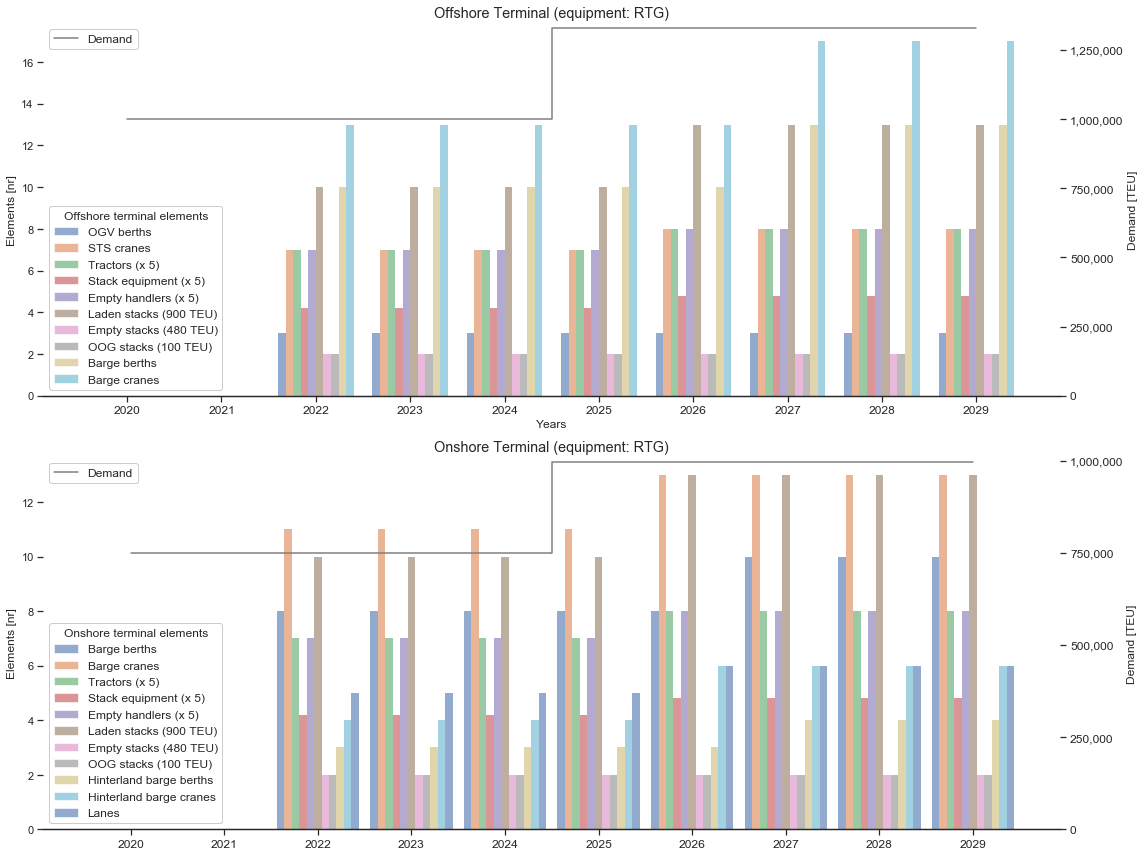

In [14]:
OffshoreBarge.terminal_elements_plot()
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/terminal_elements_1.png", bbox_inches = 'tight')
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/terminal_elements_2.png", bbox_inches = 'tight')

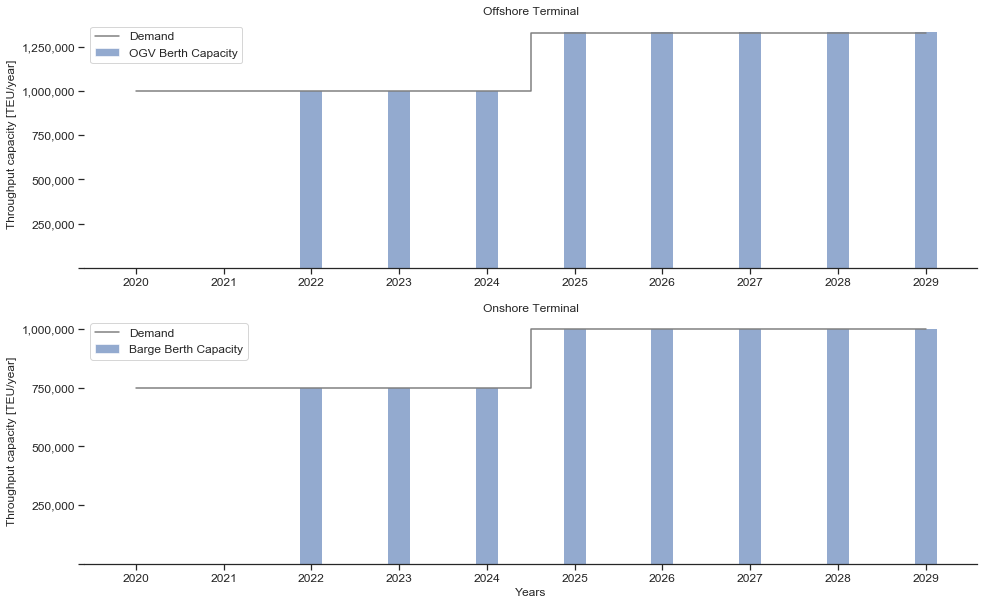

In [15]:
OffshoreBarge.terminal_capacity_plot()
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/terminal_capacity_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/terminal_capacity_2.png")

,OGV apron (ha),Laden stack (ha),OOG stack (ha),Empty stack (ha),General services (ha),Barge area (ha),Total storage (ha),Total land use (ha)
Year,,,,,,,,
2020,0.000,0.00000,0.000,0.00000,0.00,0.0000,0.00000,0.00000
2021,0.000,0.00000,0.000,0.00000,0.00,0.0000,0.00000,0.00000
2022,12.723,6.60960,1.344,0.58752,0.76,6.4000,8.54112,28.42412
2023,12.723,6.60960,1.344,0.58752,0.76,6.4000,8.54112,28.42412
2024,12.723,6.60960,1.344,0.58752,0.76,6.4000,8.54112,28.42412
2025,12.723,6.60960,1.344,0.58752,0.76,6.4000,8.54112,28.42412
2026,12.723,8.59248,1.344,0.58752,0.76,6.4000,10.52400,30.40700
2027,12.723,8.59248,1.344,0.58752,0.76,8.2975,10.52400,32.30450
2028,12.723,8.59248,1.344,0.58752,0.76,8.2975,10.52400,32.30450


,Barge apron (ha),Laden stack (ha),OOG stack (ha),Empty stack (ha),General services (ha),Hinterland barge area (ha),Gate area (ha),Total storage (ha),Total land use (ha)
Year,,,,,,,,,
2020,0.000,0.00000,0.000,0.00000,0.00,0.0000,0.000000,0.00000,0.000000
2021,0.000,0.00000,0.000,0.00000,0.00,0.0000,0.000000,0.00000,0.000000
2022,5.135,9.91440,2.016,0.88128,0.88,1.9725,0.144375,12.81168,20.943555
2023,5.135,9.91440,2.016,0.88128,0.88,1.9725,0.144375,12.81168,20.943555
2024,5.135,9.91440,2.016,0.88128,0.88,1.9725,0.144375,12.81168,20.943555
2025,5.135,9.91440,2.016,0.88128,0.88,1.9725,0.144375,12.81168,20.943555
2026,5.135,12.88872,2.016,0.88128,0.88,1.9725,0.173250,15.78600,23.946750
2027,6.400,12.88872,2.016,0.88128,0.88,2.6050,0.173250,15.78600,25.844250
2028,6.400,12.88872,2.016,0.88128,0.88,2.6050,0.173250,15.78600,25.844250


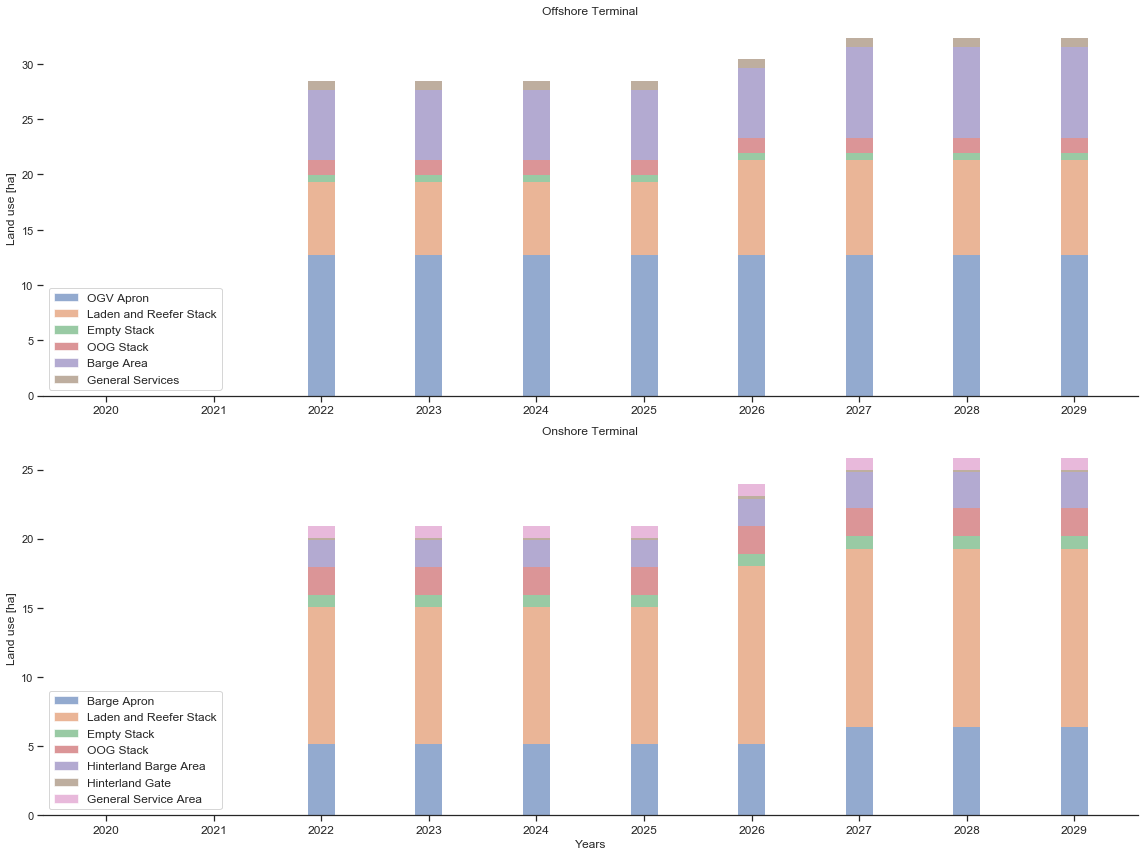

In [16]:
OffshoreBarge.terminal_land_use_plot(True)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/storage_area_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/storage_area_2.png")

,Laden storage (TEU),Empty storage (TEU),OOG storage (TEU),Total storage (TEU)
Year,,,,
2020,0,0,0,0
2021,0,0,0,0
2022,9000,960,200,10160
2023,9000,960,200,10160
2024,9000,960,200,10160
2025,9000,960,200,10160
2026,11700,960,200,12860
2027,11700,960,200,12860
2028,11700,960,200,12860


,Laden storage (TEU),Empty storage (TEU),OOG storage (TEU),Total storage (TEU)
Year,,,,
2020,0.0,0.0,0.0,0.0
2021,0.0,0.0,0.0,0.0
2022,13500.0,1440.0,300.0,15240.0
2023,13500.0,1440.0,300.0,15240.0
2024,13500.0,1440.0,300.0,15240.0
2025,13500.0,1440.0,300.0,15240.0
2026,17550.0,1440.0,300.0,19290.0
2027,17550.0,1440.0,300.0,19290.0
2028,17550.0,1440.0,300.0,19290.0


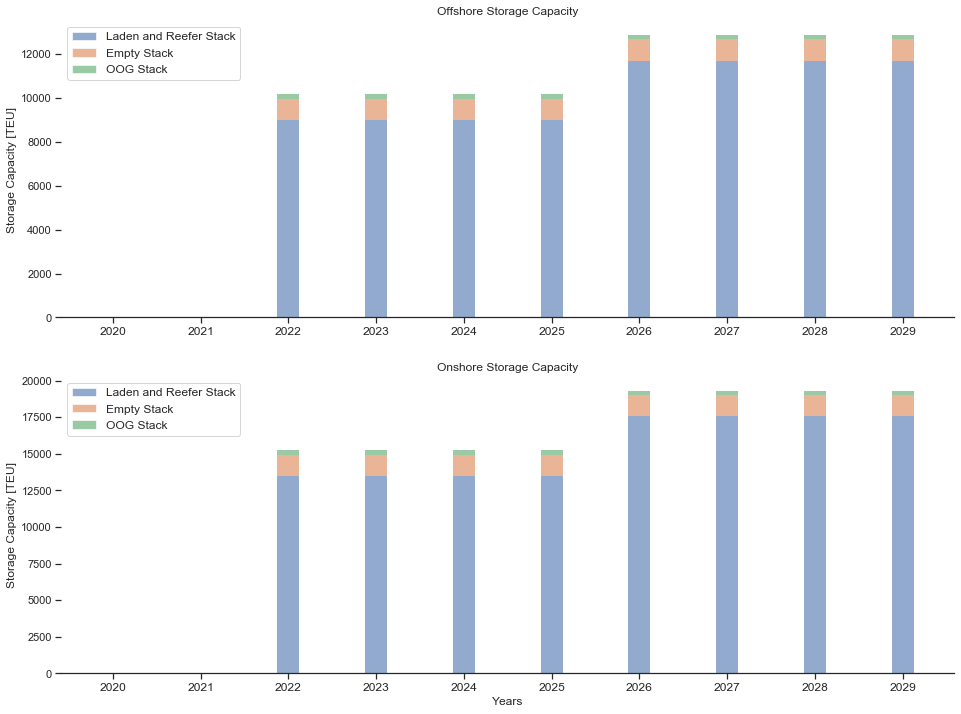

In [17]:
OffshoreBarge.storage_capacity_plot(True)
sns.despine(left=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/storage_capacity_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/storage_capacity_2.png")

In [18]:
hide_columns_list = ['Coastal Protection', 'Coastal Structures Maintenance',
                     'Offshore Maintenance', 'Offshore Insurance', 'Offshore Energy', 
                     'Offshore Labour', 'Offshore Fuel', 'Demurrage',
                     'Onshore Maintenance', 'Onshore Insurance', 'Onshore Energy', 
                     'Onshore Labour', 'Onshore Fuel', 'Demurrage']
cash_flows_real_df.style.hide_columns(hide_columns_list).hide_index()

Year,Reclamation,Offshore Capex,Onshore Capex,Ocean Transport,Barge Capex,Barge Operations,Barge Maintenance,Barge Labour,Capital Dredging,Maintenance Dredging
2020,1.26207e+08,1.82826e+08,5.25696e+07,0,0,0,0,0,2.22378e+07,0
2021,0,4.00322e+08,2.88089e+08,0,5.00481e+07,0,0,0,2.14031e+07,0
2022,1.97132e+07,0,0,5.55802e+07,0,3.82868e+06,2.40848e+06,2.70954e+06,0,1.48318e+06
2023,0,0,0,5.34939e+07,0,3.68496e+06,2.31807e+06,2.60783e+06,0,1.42751e+06
2024,0,0,0,5.1486e+07,0,3.54664e+06,2.23106e+06,2.50994e+06,0,1.37392e+06
2025,2.76263e+07,4.30455e+07,5.3691e+07,4.95534e+07,1.32142e+07,3.41352e+06,2.14731e+06,2.41573e+06,0,1.32235e+06
2026,0,3.90467e+07,7.45743e+06,4.76934e+07,0,4.29628e+06,2.70262e+06,3.04045e+06,0,1.27272e+06
2027,0,0,0,6.10512e+07,0,4.13501e+06,2.60118e+06,2.92633e+06,0,1.22494e+06
2028,0,0,0,5.87596e+07,0,3.9798e+06,2.50354e+06,2.81648e+06,0,1.17896e+06
2029,0,0,0,5.6554e+07,0,3.83041e+06,2.40957e+06,2.71076e+06,0,1.13471e+06


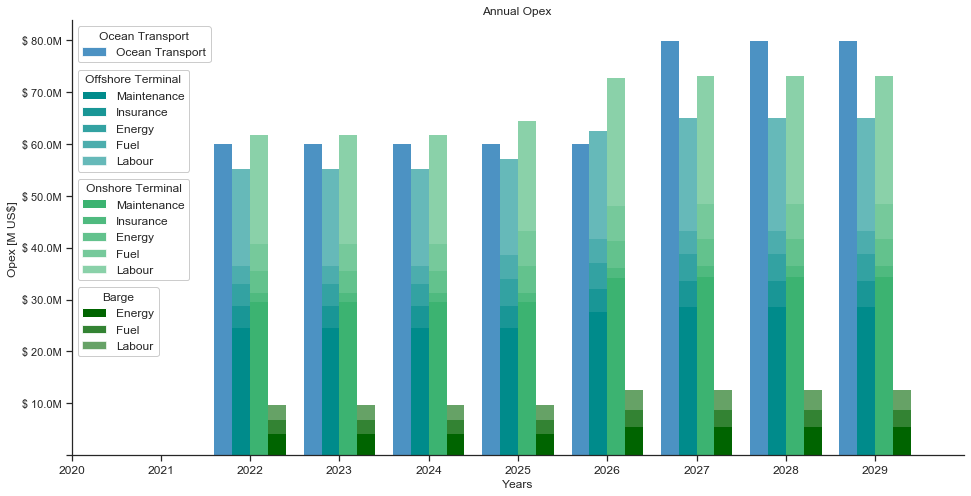

In [19]:
OffshoreBarge.terminal_opex_plot(cash_flows_df, False)
sns.despine(top=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/opex_1.png")
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/opex_2.png")

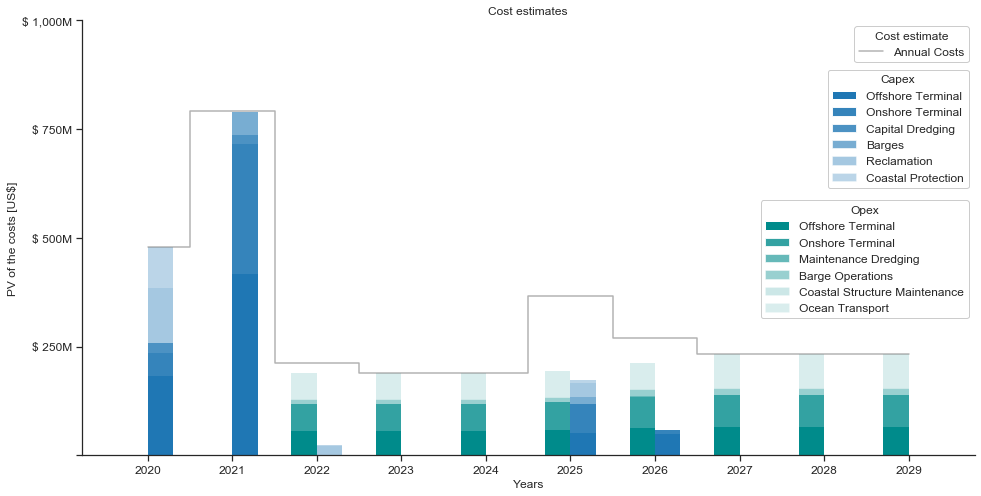

In [20]:
OffshoreBarge.cashflow_plot(cash_flows_df)
sns.despine(top=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_1.png", bbox_inches = 'tight')
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_2.png", bbox_inches = 'tight')

 ** PV of the costs: $2,804,000,000.0


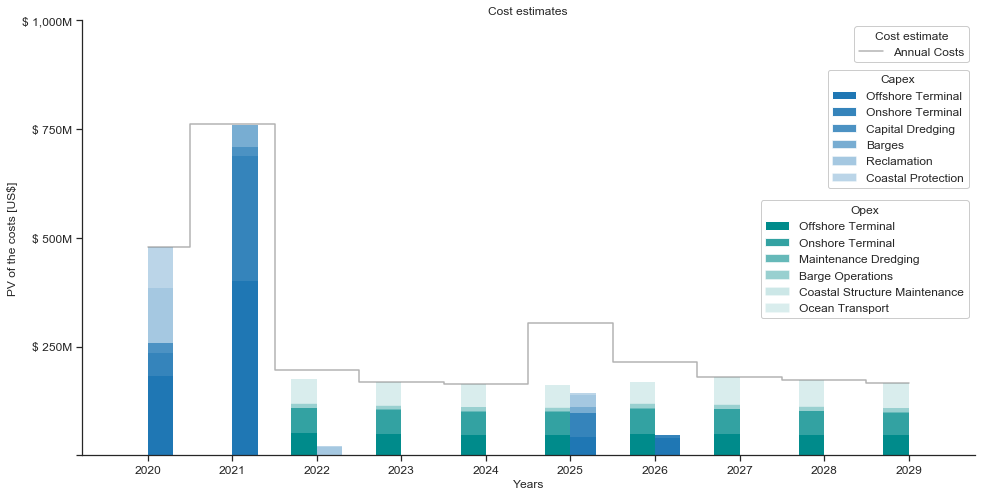

In [21]:
print(' ** PV of the costs: ${}'.format(f'{round(PV,-6):,}'))

OffshoreBarge.cashflow_plot(cash_flows_real_df)
sns.despine(top=True)

# save fig
if lifecycle == 10:
    if scenario_demand == demand_0:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_real_1.png", bbox_inches = 'tight')
    if scenario_demand == demand_2:
        plt.savefig("SaveFigures/Alt_2/cash_flow_plot_real_2.png", bbox_inches = 'tight')

,Element,Costs
0,Reclamation,1.735463e+08
1,Offshore Capex,6.652405e+08
2,Offshore Opex,3.879496e+08
3,Onshore Capex,4.018071e+08
4,Onshore Opex,4.374169e+08
5,Capital Dredging,4.364091e+07
6,Main. Dredging,1.041829e+07
7,Barge Investment,6.326236e+07
8,Barge Operations,7.177419e+07
9,Ocean Transport,4.341716e+08


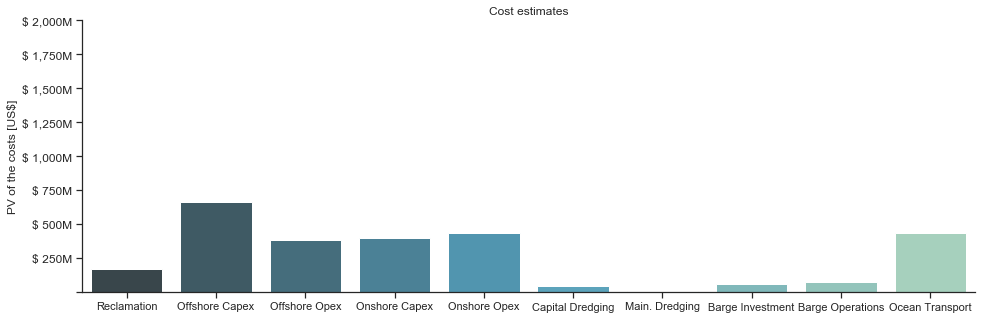

In [22]:
OffshoreBarge.element_cashflow_plot(fig_x = 16, fig_y = 5)
sns.despine(top=True)

In [23]:
print("Offshore terminal capacity for initial demand:")
total_offshore_ground_slots, total_offshore_stack_capacity, total_offshore_stack_online = OffshoreBarge.total_stack_capacity(2022)

total_offshore_ground_slots = round(total_offshore_ground_slots,-1)
total_offshore_stack_capacity = round(total_offshore_stack_capacity,-1)
      
%store total_offshore_stack_capacity

Offshore terminal capacity for initial demand:
     Total Ground Slots required   (@ start of year):  1,841
     Total Stack capacity required (@ start of year):  9,400 TEU
     Total Stack capacity online   (@ start of year):  10,200 TEU

Stored 'total_offshore_stack_capacity' (int)
